# Add_3.095 run on salish

In [1]:
from __future__ import division, print_function

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

from salishsea_tools import (
    nc_tools,
    viz_tools,
)
%matplotlib inline

In [2]:
tracers = nc.Dataset('SalishSea_1h_20020915_20020915_grid_T.nc')

In [3]:
nc_tools.show_variables(tracers)

[u'deptht', u'nav_lat', u'nav_lon', u'rain_rate', u'snow_rate', u'sossheig', u'time_counter', u'time_counter_bnds', u'vosaline', u'votemper']


In [4]:
salinity = tracers.variables['vosaline']
lon = tracers.variables['nav_lon']
lat = tracers.variables['nav_lat']

(0, 398, 0, 898)

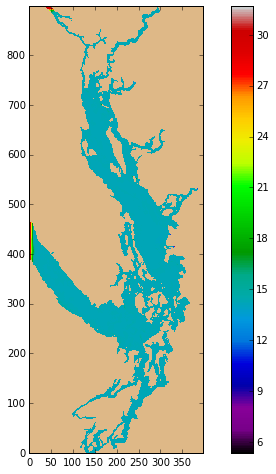

In [5]:
t, zlevel = 0, 0
salinity_tz = np.ma.masked_values(salinity[t, zlevel], 0)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)
cmap = plt.get_cmap('spectral')
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(salinity_tz, cmap=cmap)
cbar = fig.colorbar(mesh)
plt.axis((0, salinity_tz.shape[1], 0, salinity_tz.shape[0]))